# Time-Series Classification: CNN1D

## Import libraries


In [1]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 20.5 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging
import keras_tuner
from tensorflow import keras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


## Set seed for reproducibility


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Data Preprocessing

### Load Data

In [4]:
data_x = np.load('x_train.npy')
data_y = np.load('y_train.npy')

In [5]:
training_labels = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain' : 6,
    'Echoes' : 7,
    'Wearing' : 8,
    'Sorrow' : 9,
    'Hey' : 10,
    'Shine' : 11
}

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=seed, stratify=data_y)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1943, 36, 6), (486, 36, 6), (1943,), (486,))

In [8]:
y_test_classes = y_test

In [9]:
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)

y_train.shape, y_test.shape

((1943, 12), (486, 12))

In [11]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 64
epochs = 100

## Model

In [21]:
def build_BiLSTM_classifier(hp):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')


    # Feature extractor
    cnn = tfkl.Conv1D(hp.Choice('convUnits',[128,256,512]),3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    dropout = tfkl.Dropout(hp.Float('dropOut0',min_value=0.0,max_value=0.8,step=0.2), seed=seed)(cnn)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(hp.Choice('lstmUnits0',[128,256,512]), return_sequences=True))(dropout)
    dropout = tfkl.Dropout(hp.Float('dropOut1',min_value=0.0,max_value=0.8,step=0.2), seed=seed)(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(hp.Choice('lstmUnits1',[128,256,512])))(dropout)
    dropout = tfkl.Dropout(hp.Float('dropOut2',min_value=0.0,max_value=0.8,step=0.2), seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics='accuracy')

    # Return the model
    return model

In [22]:
model = build_BiLSTM_classifier()
model.summary()

TypeError: ('Keyword argument not understood:', 'return_sequences')

### Training

In [14]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_BiLSTM_classifier,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=1,
    overwrite=False,
    directory="hp_tuning",
    project_name="hw1_lstm_bayesian_1.0",
)
tuner.search_space_summary()


Search space summary
Default search space size: 5
convUnits0 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
convUnits1 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
convUnits2 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
convUnits3 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [16]:
tuner.search(x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.15,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ])


Trial 30 Complete [00h 02m 35s]
val_accuracy: 0.4623287618160248

Best val_accuracy So Far: 0.6952054500579834
Total elapsed time: 01h 35m 05s
INFO:tensorflow:Oracle triggered exit


In [15]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=input_shape)
best_model.summary()
best_model.save("tuned_BiLSTM_1.0")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 128)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 18, 256)          263168    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 18, 256)           0     

INFO:tensorflow:Assets written to: tuned_BiLSTM_1.0/assets


INFO:tensorflow:Assets written to: tuned_BiLSTM_1.0/assets


In [16]:
tuner.results_summary()


Results summary
Results in hp_tuning/hw1_lstm_1.0
Showing 10 best trials
Trial summary
Hyperparameters:
convUnits: 128
dropOut0: 0.2
lstmUnits0: 128
dropOut1: 0.2
lstmUnits1: 256
dropOut2: 0.4
lr: 0.00011629110548265889
Score: 0.7128205299377441
Trial summary
Hyperparameters:
convUnits: 256
dropOut0: 0.0
lstmUnits0: 256
dropOut1: 0.2
lstmUnits1: 512
dropOut2: 0.4
lr: 0.00014274834460539245
Score: 0.7076923251152039
Trial summary
Hyperparameters:
convUnits: 128
dropOut0: 0.0
lstmUnits0: 128
dropOut1: 0.6000000000000001
lstmUnits1: 512
dropOut2: 0.2
lr: 0.0006411826947988156
Score: 0.7025641202926636
Trial summary
Hyperparameters:
convUnits: 256
dropOut0: 0.4
lstmUnits0: 512
dropOut1: 0.6000000000000001
lstmUnits1: 512
dropOut2: 0.0
lr: 0.0004957077012922462
Score: 0.6974359154701233
Trial summary
Hyperparameters:
convUnits: 512
dropOut0: 0.2
lstmUnits0: 128
dropOut1: 0.6000000000000001
lstmUnits1: 128
dropOut2: 0.4
lr: 0.00013417288729783997
Score: 0.6974359154701233
Trial summary
Hyper

In [29]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-12 09:37:48.824624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:49.101899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:49.113756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:49.218637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:49.229759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:49.384484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:49.400242: I tensorflow/core/grappler/optimizers/cust

 1/55 [..............................] - ETA: 3:20 - loss: 2.5468 - accuracy: 0.0938

2022-12-12 09:37:49.599812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 1.7571 - accuracy: 0.3987

2022-12-12 09:37:53.877640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:53.976662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:53.985540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:54.072953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 09:37:54.081474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 8s 88ms/step - loss: 1.7571 - accuracy: 0.3987 - val_loss: 1.4441 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 3s 57ms/step - loss: 1.4297 - accuracy: 0.5029 - val_loss: 1.2156 - val_accuracy: 0.5590 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 3s 54ms/step - loss: 1.2806 - accuracy: 0.5572 - val_loss: 1.1782 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 3s 56ms/step - loss: 1.2245 - accuracy: 0.5715 - val_loss: 1.1765 - val_accuracy: 0.5744 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 3s 56ms/step - loss: 1.1382 - accuracy: 0.6041 - val_loss: 1.0690 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 3s 55ms/step - loss: 1.1163 - accuracy: 0.6087 - val_loss: 1.0514 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 3s 54ms/step - loss: 1.0618 -

## Plot

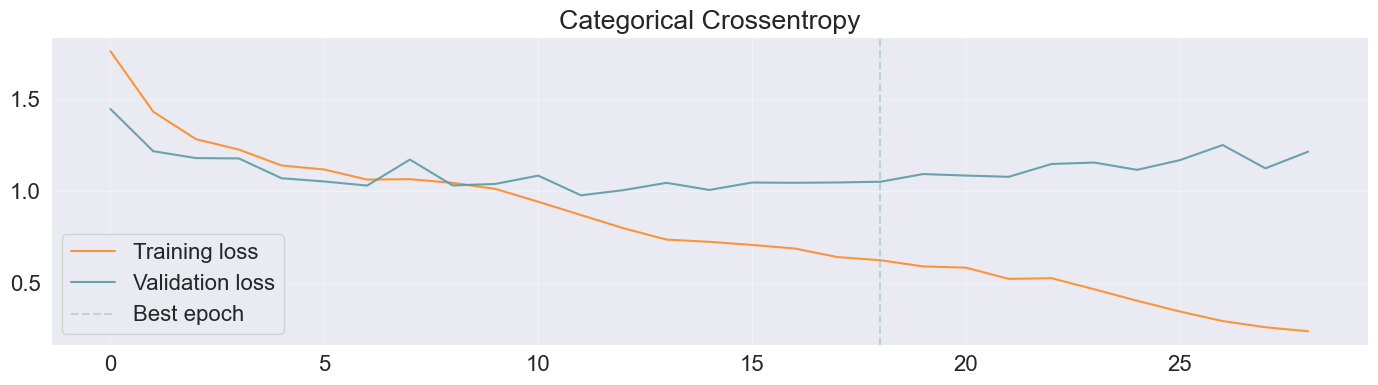

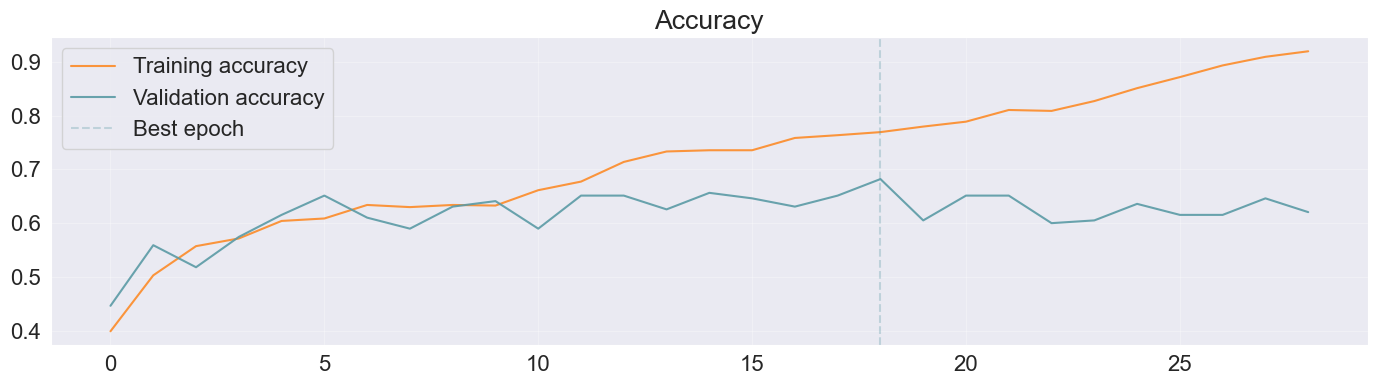

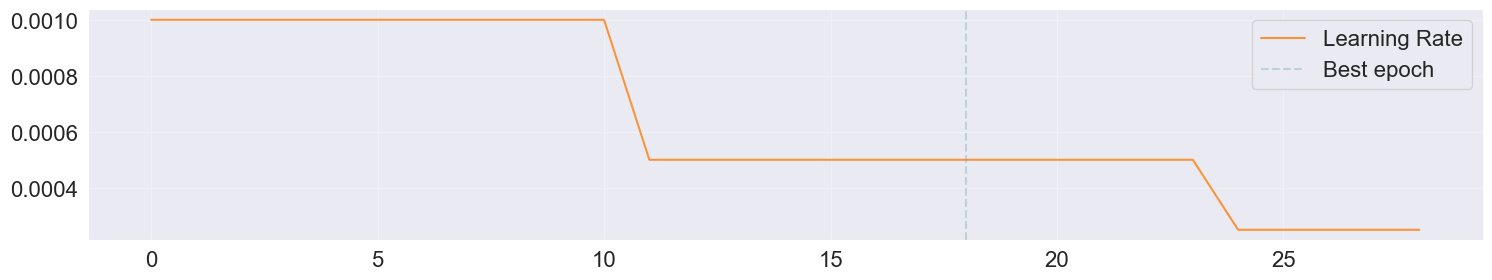

In [30]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Confusion Matrix

In [21]:
predictions = best_model.predict(X_test)

16/16 [==============================] - 0s 5ms/step


In [22]:
# Get most likely classes
predicted_classes = np.argmax(predictions, axis=-1)

In [23]:
true_classes = y_test_classes

Accuracy: 0.6543
Precision: 0.6079
Recall: 0.5197
F1: 0.5281


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


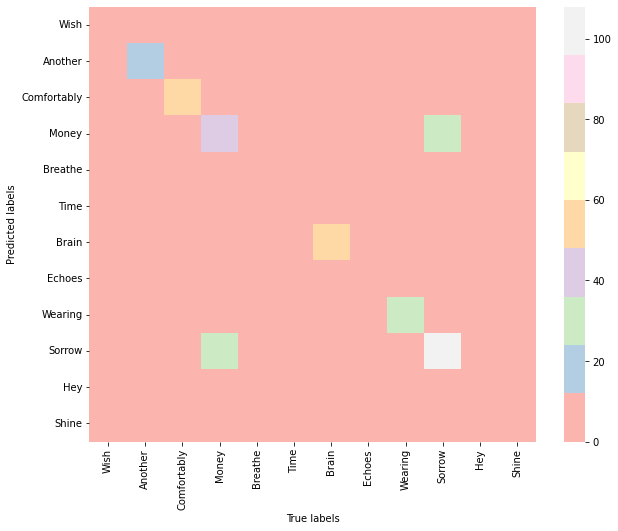

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Pastel1', xticklabels=training_labels, yticklabels=training_labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Save Model

In [18]:
#model.save('1dBiLSTM')